In [1]:
import torch

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
from torchvision import transforms, datasets, utils

BATCH_SIZE = 64

transform_CIFAR10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_dataset = datasets.CIFAR10(root = '../data',
                                         train = True,
                                         download = True,
                                         transform = transform_CIFAR10)

test_dataset = datasets.CIFAR10(root = '../data',
                                train = False,
                                download = True,
                                transform = transform_CIFAR10)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
from torchsummary import summary

class Custom_CNN(nn.Module):
    def __init__(self):
        super(Custom_CNN, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2d_4 = nn.MaxPool2d(kernel_size=4)
        self.dropout = nn.Dropout2d(p=0.5)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1) 
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)


    def forward(self, x): #(3,32,32)
        x = self.maxpool2d_2(self.relu((self.conv1(x)))) #(64,16,16)
        x = self.maxpool2d_2(self.relu((self.conv2(x)))) #(32,8,8)
        x = self.maxpool2d_4(self.relu((self.conv3(x)))) #(16,2,2)
        x = x.view(-1,64)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = Custom_CNN().to(DEVICE)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          18,464
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 16, 8, 8]           4,624
              ReLU-8             [-1, 16, 8, 8]               0
         MaxPool2d-9             [-1, 16, 2, 2]               0
           Linear-10                   [-1, 64]           4,160
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [4]:
import torch.optim as optim

LR = 0.01

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

In [5]:
import torch.nn.functional as F

def train_one_epoch(model, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [6]:
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.310965
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.304739
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.301048
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.146005
[1] Test Loss: 2.0196, Accuracy: 25.25%
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.002597
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.932432
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.780256
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.713923
[2] Test Loss: 1.7204, Accuracy: 36.86%
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.570694
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.773932
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.620071
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.634542
[3] Test Loss: 1.6288, Accuracy: 41.15%


In [7]:
CLASSES = dict()
for i in range(10) :
    CLASSES[i] = train_dataset.classes[i]

print(CLASSES)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


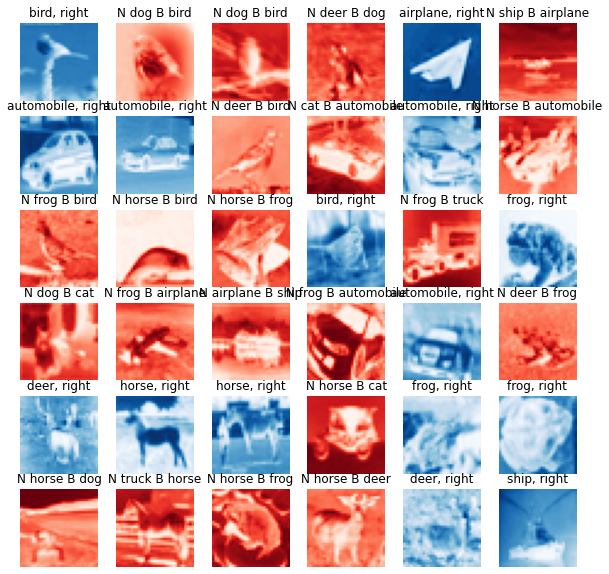

In [8]:
import numpy as np
import matplotlib.pyplot as plt

columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[test_dataset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 